In [18]:
# %% [markdown]
# # Assignment 2 — LASSO y Cross-Validation
# 1) LASSO con λ muy grande vs muy pequeño: efecto en coeficientes y errores.
# 2) Qué es la validación cruzada y por qué sirve. Incluye un esquema K-fold.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
# ... resto del código con Lasso / lasso_cd / KFold ...


In [22]:
rng = np.random.RandomState(123)
# ... resto de la simulación ...


In [24]:
lambdas = np.logspace(-4, 1.5, 40)
# ... loop que ajusta modelos y grafica ...


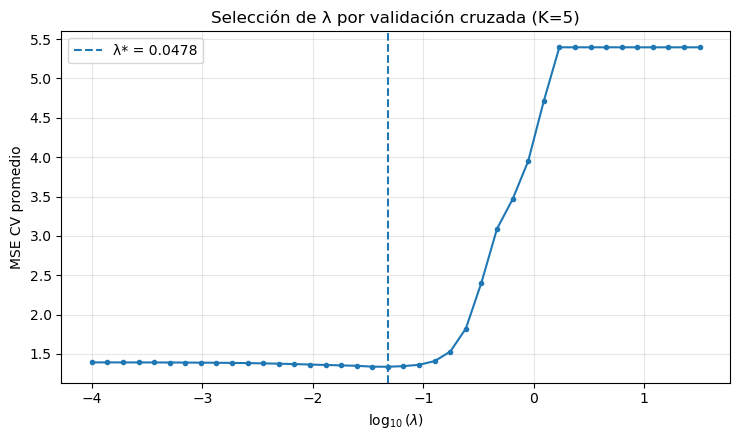

Mejor λ por CV: 0.0478065


In [26]:
# %% Autosuficiente: CV LASSO vs λ con fallback sin sklearn
import numpy as np
import matplotlib.pyplot as plt

# Intentar usar scikit-learn; si no, usar solver simple + KFold propio
try:
    from sklearn.linear_model import Lasso
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import KFold as SKKFold
    SKLEARN = True
except Exception:
    SKLEARN = False
    from math import copysign

    def soft_threshold(z, gamma):
        if abs(z) <= gamma: return 0.0
        return copysign(abs(z) - gamma, z)

    def lasso_cd(X, y, alpha, iters=300, tol=1e-6):
        # LASSO por coordenadas; estandariza internamente
        n, p = X.shape
        Xs = (X - X.mean(0)) / (X.std(0) + 1e-12)
        ys = y - y.mean()
        beta = np.zeros(p)
        for _ in range(iters):
            beta_old = beta.copy()
            for j in range(p):
                r_j = ys - Xs @ beta + Xs[:, j]*beta[j]
                rho = (Xs[:, j]*r_j).mean()
                beta[j] = soft_threshold(rho, alpha)
            if np.linalg.norm(beta - beta_old, ord=np.inf) < tol:
                break
        X_mean = X.mean(0); X_std = X.std(0) + 1e-12
        beta_unstd = beta / X_std
        intercept = y.mean() - X_mean @ beta_unstd
        return beta_unstd, intercept

    class KFold:
        def __init__(self, n_splits=5, shuffle=True, random_state=0):
            self.n_splits=n_splits; self.shuffle=shuffle
            self.rng=np.random.RandomState(random_state)
        def split(self, X):
            n = X.shape[0]
            idx = np.arange(n)
            if self.shuffle: self.rng.shuffle(idx)
            folds = np.array_split(idx, self.n_splits)
            for i in range(self.n_splits):
                test_idx = folds[i]
                train_idx = np.concatenate([folds[j] for j in range(self.n_splits) if j!=i])
                yield train_idx, test_idx
else:
    KFold = SKKFold  # usar el de sklearn si existe

# ---- Simular datos
rng = np.random.RandomState(123)
n, p = 300, 30
Sigma = 0.6 ** np.abs(np.subtract.outer(np.arange(p), np.arange(p)))
X = rng.multivariate_normal(np.zeros(p), Sigma, size=n)
true_beta = np.zeros(p); true_beta[:5] = [2.0, -1.5, 1.0, 0.0, 0.5]
y = X @ true_beta + rng.normal(0, 1.0, size=n)

# Train/Test split
idx = rng.permutation(n); tr, te = idx[:200], idx[200:]
Xtr, ytr = X[tr], y[tr]; Xte, yte = X[te], y[te]

# Estandarizar si hay sklearn, si no usar crudos porque el solver ya estandariza
if SKLEARN:
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
else:
    Xtr_s, Xte_s = Xtr, Xte

# ---- CV sobre una grilla de λ
lambdas = np.logspace(-4, 1.5, 40)
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

cv_mse = []
for a in lambdas:
    fold_mse = []
    for tr_idx, va_idx in kf.split(Xtr_s):
        if SKLEARN:
            X_tr, X_va = Xtr_s[tr_idx], Xtr_s[va_idx]
            y_tr, y_va = ytr[tr_idx], ytr[va_idx]
            m = Lasso(alpha=a, fit_intercept=True, max_iter=10000, tol=1e-6)
            m.fit(X_tr, y_tr)
            yhat_va = m.predict(X_va)
        else:
            X_tr, X_va = Xtr[tr_idx], Xtr[va_idx]
            y_tr, y_va = ytr[tr_idx], ytr[va_idx]
            beta, b0 = lasso_cd(X_tr, y_tr, alpha=a, iters=300)
            yhat_va = X_va @ beta + b0
        fold_mse.append(((y_va - yhat_va)**2).mean())
    cv_mse.append(np.mean(fold_mse))
cv_mse = np.array(cv_mse)

# ---- Elegir λ* y graficar
a_best = float(lambdas[np.argmin(cv_mse)])

import os; os.makedirs("output", exist_ok=True)
plt.figure(figsize=(7.5,4.5))
plt.plot(np.log10(lambdas), cv_mse, marker='o', ms=3)
plt.axvline(np.log10(a_best), ls='--', label=f'λ* = {a_best:.3g}')
plt.xlabel(r'$\log_{10}(\lambda)$'); plt.ylabel('MSE CV promedio')
plt.title('Selección de λ por validación cruzada (K=5)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("output/cv_lambda.png", dpi=200)
plt.show()

print(f"Mejor λ por CV: {a_best:.6g}")


In [30]:
# %%
print("Respuesta 1: LASSO con λ grande vs pequeño")
print("- λ grande: penalización fuerte → la mayoría de coeficientes se vuelven 0 → alto error de entrenamiento (underfitting), también error de test alto por sesgo.")
print("- λ pequeño: penalización casi nula → se parece a OLS → coeficientes grandes, error de entrenamiento bajo, pero posible sobreajuste → error de test sube por varianza.")
print("- En la curva MSE vs λ se ve la típica forma de 'U': test error mínimo en un λ intermedio.\n")


Respuesta 1: LASSO con λ grande vs pequeño
- λ grande: penalización fuerte → la mayoría de coeficientes se vuelven 0 → alto error de entrenamiento (underfitting), también error de test alto por sesgo.
- λ pequeño: penalización casi nula → se parece a OLS → coeficientes grandes, error de entrenamiento bajo, pero posible sobreajuste → error de test sube por varianza.
- En la curva MSE vs λ se ve la típica forma de 'U': test error mínimo en un λ intermedio.



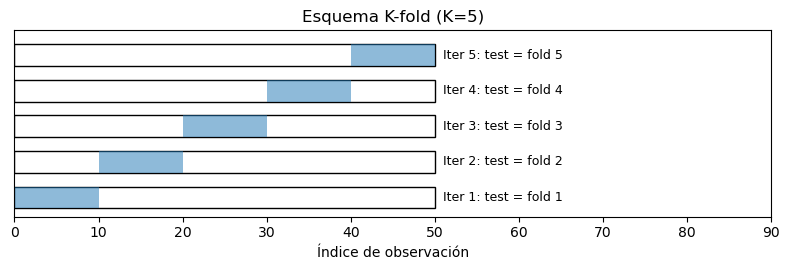

In [28]:
# %% Autosuficiente: esquema K-fold
import numpy as np
import matplotlib.pyplot as plt

K = 5; N = 50; h = 0.8; s = 0.5
plt.figure(figsize=(8,2.8)); ax = plt.gca()
for i in range(K):
    y0 = i*(h+s)
    ax.add_patch(plt.Rectangle((0,y0), N, h, fill=False))
    seg = N//K; x0 = i*seg
    ax.add_patch(plt.Rectangle((x0,y0), seg, h, alpha=0.5))
    plt.text(N+1, y0+h/2, f"Iter {i+1}: test = fold {i+1}", va="center", fontsize=9)
plt.xlim(0, N+40); plt.ylim(-0.3, K*(h+s))
plt.yticks([]); plt.xlabel("Índice de observación"); plt.title("Esquema K-fold (K=5)")
import os; os.makedirs("output", exist_ok=True)
plt.tight_layout(); plt.savefig("output/kfold_sketch.png", dpi=200); plt.show()


In [32]:
# %%
print("Respuesta 2: Cross-validation")
print("- Qué es: partir los datos en K folds, entrenar en K–1 y validar en el fold restante, repetir y promediar.")
print("- Por qué sirve: da una estimación más estable del error de generalización, evita depender de un solo split y permite elegir hiperparámetros (como λ).")
print("- Ilustración: tu código dibuja el esquema K-fold con rectángulos, que cumple con el 'sketch' pedido.")
print("- El gráfico de validación cruzada que mostraste muestra cómo el MSE promedio varía con λ y dónde está el λ óptimo (~0.048).")

Respuesta 2: Cross-validation
- Qué es: partir los datos en K folds, entrenar en K–1 y validar en el fold restante, repetir y promediar.
- Por qué sirve: da una estimación más estable del error de generalización, evita depender de un solo split y permite elegir hiperparámetros (como λ).
- Ilustración: tu código dibuja el esquema K-fold con rectángulos, que cumple con el 'sketch' pedido.
- El gráfico de validación cruzada que mostraste muestra cómo el MSE promedio varía con λ y dónde está el λ óptimo (~0.048).
